# Captcha Recognition in Images

# Обзор проекта
Этот проект демонстрирует использование методов глубокого обучения для распознавания текста на изображениях. Основная архитектура модели — сверточно-рекуррентная нейронная сеть (CRNN) с использованием функции потерь CTC (Connectionist Temporal Classification).

# Архитектура модели
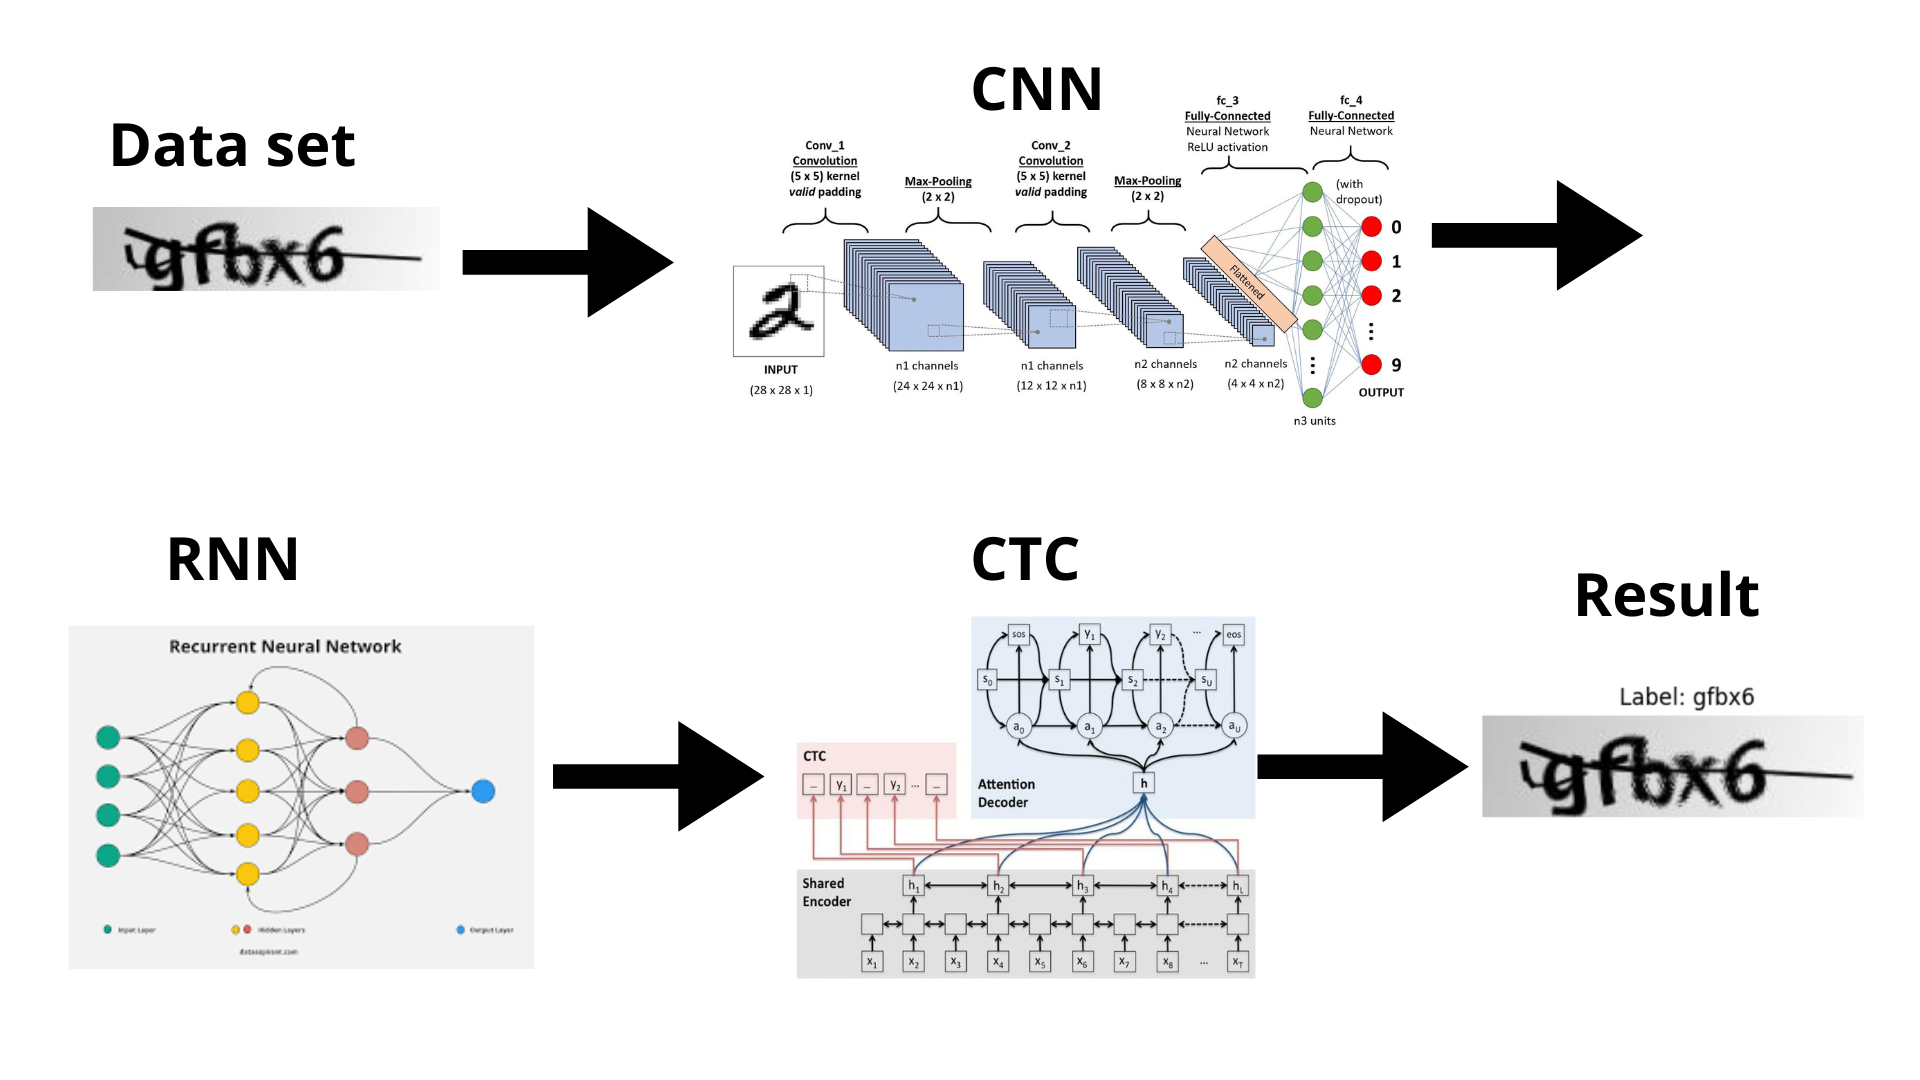

## Сверточно-рекуррентная нейронная сеть (CRNN)
CRNN — это гибридная архитектура, объединяющая сверточные нейронные сети (CNN) и рекуррентные нейронные сети (RNN). Такая структура идеально подходит для задач распознавания последовательностей на изображениях, например, распознавания текста.

### Основные компоненты модели:
- **Сверточные слои (CNN):** выполняют извлечение признаков с изображений — таких как края, текстуры и формы.
- **Рекуррентные слои (LSTM):** двухнаправленные LSTM-слои анализируют последовательности признаков и выявляют зависимости между символами.
- **Выходной слой:** слой с активацией softmax предсказывает вероятности каждого символа на каждом временном шаге.

# Функция потерь — Connectionist Temporal Classification (CTC)
## Что такое CTC Loss?
CTC Loss используется в задачах, где входная и выходная последовательности имеют разную длину, а соответствие между ними заранее неизвестно (например, текст в изображении).

### Как работает CTC Loss:
- **Кодирование меток:** текст преобразуется в последовательность символов.
- **Вычисление потерь:** CTC считает вероятность получения правильной последовательности, учитывая все возможные выравнивания.
- **Обработка разной длины:** вводится специальный символ "blank", который позволяет выравнивать последовательности с пропусками.

### Зачем нужен CTC Loss:
- Распознавание текста без необходимости знать точные позиции символов в изображении.
- Поддержка текстов разной длины.
- Обучение моделей "end-to-end" без этапов ручной локализации текста.


# Цель проекта
Этот код объединяет архитектуру CRNN и функцию потерь CTC для построения модели распознавания текста. В нем продемонстрированы этапы подготовки данных, построение и обучение модели, а также сохранение модели для дальнейшего использования.

Применение данной модели возможно в задачах OCR (оптическое распознавание символов), автоматизированного ввода данных и в других проектах, где требуется распознавание текста с изображений.


# Подключение Google Drive к Google Colab
Для загрузки набора данных, расположенного в облачном хранилище, используется стандартная команда:

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Импорт библиотек и фреймворков
 Этот блок кода начинается с импорта необходимых библиотек Python и компонентов TensorFlow. Эти библиотеки и компоненты играют ключевую роль в построении и обучении сверточно-рекуррентной нейронной сети (CRNN) с использованием функции потерь Connectionist Temporal Classification (CTC)

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, Bidirectional, LSTM, Dense, Lambda, Rescaling, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode

#Предобработка данных и создание датасета

Определение параметров:

image_height, image_width — размеры изображений капчи.

batch_size — размер батча для обучения.

Загрузка путей к изображениям и меток:

Составляется список всех файлов .png из папки на Google Диске.

Метки (тексты капчи) берутся из имён файлов.

Определение максимальной длины капчи:

Вычисляется максимальная длина текста среди всех изображений.

Создание набора символов:

Формируется список всех уникальных символов, встречающихся в метках.

Создание отображения символов в числа:

Создаются словари для кодирования (символ → число) и декодирования (число → символ).

Функция предобработки изображений:

Считывание файла изображения, перевод в оттенки серого и изменение размера.

Предобработка изображений и меток:

Изображения обрабатываются через функцию.

Метки кодируются в числовые последовательности.

Создание TensorFlow Dataset:

Создаётся объект dataset, объединяющий изображения и кодированные метки.

Перемешивание и разделение на обучающую и валидационную выборки:

Данные перемешиваются.

80% используется для обучения (train_dataset), 20% для валидации (validation_dataset).

In [4]:

image_height, image_width = 50, 200
batch_size = 16

image_dir = Path('/content/drive/MyDrive/captcha_images_v2')

image_paths = [str(image) for image in sorted(Path(image_dir).glob("*.png"))]
labels = [image.stem for image in sorted(Path(image_dir).glob("*.png"))]

max_length = max([len(label) for label in labels])

all_possible_characters = sorted(set("".join(labels)))

char_to_int = {char: i for i, char in enumerate(all_possible_characters)}
int_to_char = {i: char for char, i in char_to_int.items()}

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, (image_height, image_width))
    return image

images = [preprocess_image(image_path) for image_path in image_paths]
encoded_labels = [[char_to_int[char] for char in label] for label in labels]

encoded_labels = tf.ragged.constant(encoded_labels)

dataset = tf.data.Dataset.from_tensor_slices((images, encoded_labels))

dataset = dataset.shuffle(buffer_size=len(images))

train_size = int(0.8 * len(image_paths))
train_dataset = dataset.take(train_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = dataset.skip(train_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

## Визуализация случайных примеров из набора данных

Этот блок определяет функцию `visualize_random_samples`, которая выполняет визуализацию случайных изображений капчи вместе с их метками.

**Функция:**
- Принимает:
  - `dataset` — tf.data.Dataset с парами (изображение, метка).
  - `int_to_char` — словарь для перевода чисел обратно в символы.
  - `num_samples` — количество отображаемых примеров.
- Работает так:
  1. Создаёт итератор по датасету.
  2. Для каждого примера:
     - Извлекает изображение и метку.
     - Преобразует метку из чисел в текст.
     - Отображает изображение через Matplotlib.
- Возвращает: ничего (только показывает изображения).



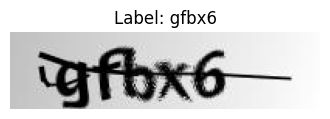

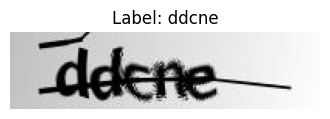

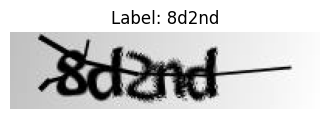

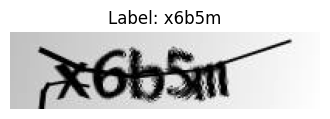

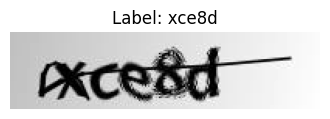

In [ ]:
def visualize_random_samples(dataset, int_to_char, num_samples=5):
    """
    Visualize random samples from a dataset.

    Args:
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        int_to_char (dict): A mapping from integer labels to characters.
        num_samples (int): The number of samples to visualize.

    Returns:
        None
    """

    dataset_iter = iter(dataset)

    for i in range(num_samples):
        image, label = next(dataset_iter)

        label = [int_to_char[int(x)] for x in label[0].numpy()]

        plt.figure(figsize=(4, 2))
        plt.imshow(image[0, :, :, 0], cmap='gray')
        plt.title("Label: " + ''.join(label))
        plt.axis('off')
        plt.show()

visualize_random_samples(validation_dataset, int_to_char, num_samples=5)


## Архитектура модели OCR

В этом разделе определяется и описывается архитектура модели для распознавания текста на изображениях капчи.

### Архитектура модели

Модель OCR состоит из следующих компонентов:

#### Входной слой
- **Форма входных данных:** `(image_height, image_width, 1)`
- **Назначение:** Определяет форму входных данных, соответствующую изображениям в оттенках серого.

#### Слой стандартизации
- **Назначение:** Масштабирует значения пикселей в диапазон [0, 1] для ускорения и стабилизации обучения.

#### Слой транспонирования
- **Назначение:** Меняет размерность входного тензора на `(None, image_width, image_height, 1)`, чтобы ширина изображения соответствовала временной оси при обучении.

#### Сверточные слои
- **Конфигурация:** Последовательность слоев Conv2D с активацией ReLU и BatchNormalization. Для уменьшения размерности используется MaxPooling2D.
- **Назначение:** Извлечение признаков с изображений (например, краев, текстур).

#### Слой преобразования формы
- **Назначение:** Преобразует тензор в форму `(image_width // 8, (image_height // 4) * 256)`, готовя данные к рекуррентным слоям.

#### Полносвязный слой (Dense)
- **Конфигурация:** Слой Dense с активацией ReLU.
- **Назначение:** Дополнительная обработка признаков перед передачей в рекуррентные слои.

#### Рекуррентные слои (двунаправленные LSTM)
- **Конфигурация:** Два слоя Bidirectional LSTM с использованием dropout.
- **Назначение:** Обработка временных зависимостей в данных с двух направлений (вперед и назад), что улучшает качество распознавания текста.

#### Выходной слой (CTC)
- **Конфигурация:** Слой Dense с активацией softmax. Количество выходов равно количеству уникальных символов + 1 (для "пустого" символа в CTC).
- **Назначение:** Генерация предсказаний для каждого временного шага. Потери рассчитываются с помощью функции CTC Loss для автоматического выравнивания предсказанных символов с истинными метками.

### Компиляция модели

Модель компилируется с оптимизатором Adam и функцией потерь CTC Loss, которая учитывает возможные несовпадения по длине между предсказаниями и метками.

### Сводка

В конце кода выводится структура модели: типы слоев, размеры выходов и количество параметров.

Эта модель предназначена для распознавания символов на изображениях капчи и может быть дополнительно обучена или улучшена с использованием различных датасетов.


In [ ]:
input_data = Input(shape=(image_height, image_width, 1), name='input_image')

x = Rescaling(1./255)(input_data)

x = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]), name="transpose")(x)

x = Conv2D(64, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), name="pool1")(x)

x = Conv2D(128, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), name="pool2")(x)

x = Conv2D(256, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 1), name="pool3")(x)

x = Reshape(target_shape=(image_width // 8, (image_height // 4) * 256), name="reshape")(x)
x = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)

output = Dense(len(all_possible_characters) + 1, activation='softmax')(x)

model = Model(inputs=input_data, outputs=output, name="OCR_model")

def ctc_loss(y_true, y_pred):
    input_length = tf.fill((batch_size, 1), tf.shape(y_pred)[1])
    label_length = tf.fill((batch_size, 1), max_length)
    loss = ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

model.compile(optimizer=Adam(), loss=ctc_loss)
model.summary()

Model: "OCR_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 50, 200, 1)]      0         
                                                                 
 rescaling (Rescaling)       (None, 50, 200, 1)        0         
                                                                 
 transpose (Lambda)          (None, 200, 50, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 200, 50, 64)       640       
                                                                 
 batch_normalization (Batch  (None, 200, 50, 64)       256       
 Normalization)                                                  
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 64)       0         
                                                         

## Обучение модели

На этом этапе начинается обучение модели OCR. Обучение будет проходить максимум 20 эпох, однако для предотвращения переобучения используется механизм ранней остановки (EarlyStopping).

### Конфигурация обучения:

- **Количество эпох:** максимум 20.
- **EarlyStopping:**  
  - Мониторинг значения функции потерь (loss) на обучающем датасете.
  - Если потери не улучшаются в течение 5 последовательных эпох, обучение автоматически остановится.
  - При остановке будут восстановлены наилучшие веса модели, достигнутые в процессе обучения.

### Зачем это нужно:

- **Предотвращение переобучения:**  
  EarlyStopping позволяет остановить обучение до достижения максимального количества эпох, если модель перестает улучшаться.
- **Экономия времени и ресурсов:**  
  Автоматическая остановка помогает избежать лишних вычислений.
- **Улучшение качества:**  
  Использование лучших весов помогает добиться лучших результатов на тестовых данных.

В процессе обучения будет отображаться ход обучения и динамика функции потерь.


In [ ]:
num_epochs = 20

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/20
52/52 [==============================] - 24s 57ms/step - loss: 17.7325 - val_loss: 16.3408
Epoch 2/20
52/52 [==============================] - 2s 30ms/step - loss: 16.1628 - val_loss: 16.4278
Epoch 3/20
52/52 [==============================] - 2s 29ms/step - loss: 16.1140 - val_loss: 16.0778
Epoch 4/20
52/52 [==============================] - 2s 40ms/step - loss: 14.1866 - val_loss: 13.2521
Epoch 5/20
52/52 [==============================] - 2s 35ms/step - loss: 5.3792 - val_loss: 2.2160
Epoch 6/20
52/52 [==============================] - 1s 29ms/step - loss: 1.1793 - val_loss: 0.8554
Epoch 7/20
52/52 [==============================] - 2s 29ms/step - loss: 0.6077 - val_loss: 0.5578
Epoch 8/20
52/52 [==============================] - 2s 30ms/step - loss: 0.3609 - val_loss: 0.2588
Epoch 9/20
52/52 [==============================] - 2s 29ms/step - loss: 0.1943 - val_loss: 0.0941
Epoch 10/20
52/52 [==============================] - 2s 29ms/step - loss: 0.1135 - val_loss: 0.0301


##Анализ истории обучения
В этом разделе проводится анализ истории обучения для определения эпохи с наименьшей ошибкой на валидационной выборке, что часто соответствует лучшей производительности модели.
Также визуализируются значения потерь на обучении и валидации по эпохам, чтобы понять, как изменялась эффективность модели в процессе обучения.

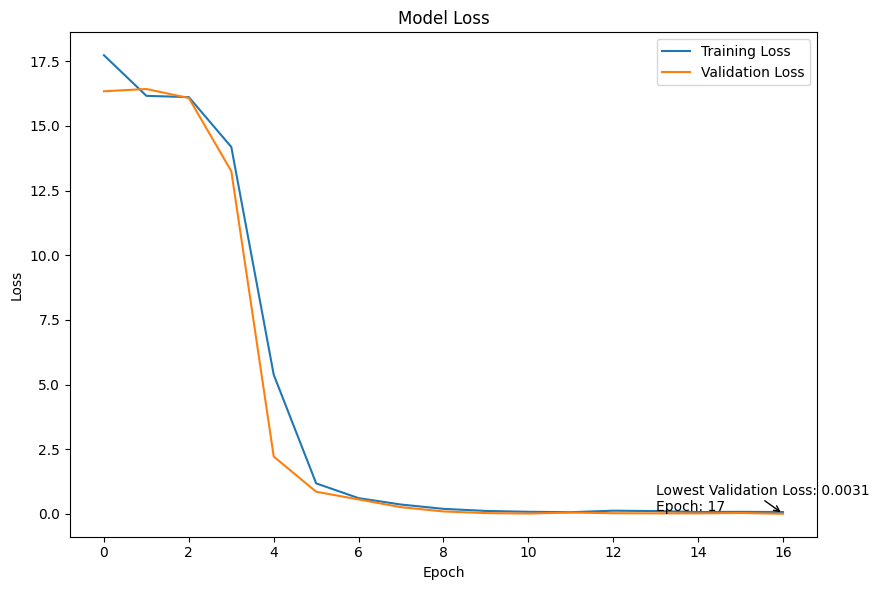

In [ ]:

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

def plot_training_history(history, best_epoch):
    plt.figure(figsize=(9, 6))

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    min_val_loss = min(history.history['val_loss'])
    plt.annotate(
        f'Lowest Validation Loss: {min_val_loss:.4f}\nEpoch: {best_epoch + 1}',
        xy=(best_epoch, min_val_loss),
        xytext=(best_epoch - 3, min_val_loss + 0.1),
        arrowprops=dict(facecolor='black', arrowstyle='->')
    )

    plt.tight_layout()
    plt.show()


plot_training_history(history, best_epoch)

## Декодирование и визуализация примеров

В этом разделе кода выполняется декодирование и визуализация случайных примеров из валидационного набора данных с использованием обученной модели CRNN (Сверточно-Рекуррентной Нейронной Сети).

### Основная цель:

- **Проверка качества модели:**  
  Наблюдение за реальными предсказаниями модели на примерах из валидационного набора данных.

- **Оценка ошибок:**  
  Визуальное сравнение предсказанных и реальных меток позволяет легко обнаружить, где модель ошибается и насколько хорошо она обучилась.

### Что происходит в этом этапе:

- Из валидационного набора данных выбираются случайные изображения.
- Каждое изображение подается на вход модели для получения предсказания.
- Предсказанная последовательность чисел преобразуется обратно в текст (декодируется).
- Отображается изображение вместе с реальной и предсказанной метками.

Этот шаг помогает получить качественное представление о том, насколько хорошо модель справляется с распознаванием капч после обучения.


1/1 [==============================] - 0s 29ms/step


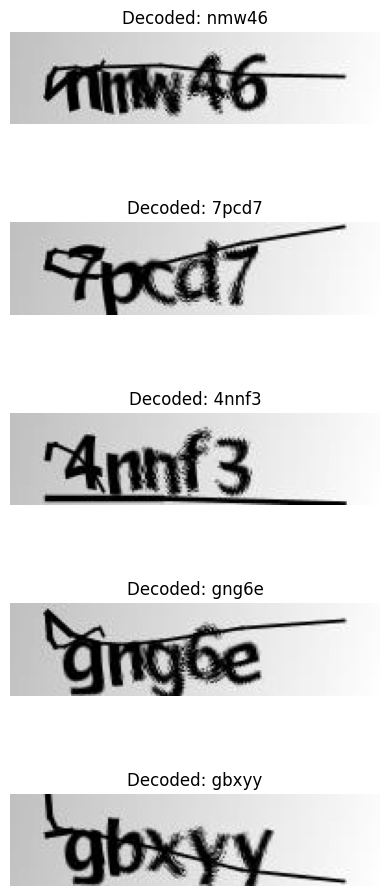

In [ ]:
def decode_and_visualize_samples(model, dataset, int_to_char, num_samples=5):
    """
    Decode and visualize random samples from a dataset using the provided model.

    Args:
        model (tf.keras.Model): The CRNN model.
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        int_to_char (dict): A mapping from integer labels to characters.
        num_samples (int): The number of samples to visualize.

    Returns:
        None
    """

    dataset_iter = iter(dataset)

    fig, axes = plt.subplots(num_samples, 1, figsize=(4, 2 * num_samples))

    for i in range(num_samples):
        image, label = next(dataset_iter)
        predictions = model.predict(image)
        decoded, _ = ctc_decode(predictions, input_length=tf.fill((batch_size,), 25), greedy=True)

        decoded_labels = [int_to_char[int(x)] for x in decoded[0][0,:max_length].numpy()]

        axes[i].imshow(image[0, :, :, 0], cmap='gray')
        axes[i].set_title("Decoded: " + ''.join(decoded_labels))
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

decode_and_visualize_samples(model, validation_dataset, int_to_char, num_samples=5)